In [3]:
from __future__ import division
from __future__ import print_function
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle

In [4]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [5]:
# File with gender included
sample10_file = '/Users/lekha/galvanize/capstone/projectRiley/data/sample10/out.txt'
sample1000_file = '/Users/lekha/galvanize/capstone/projectRiley/data/cleandatagender1000.txt'
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/cleandatagenderall.txt'

uwash_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender_uwash.txt'
holyoke_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender_holyoke.txt'
utaustin_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender_utaustin.txt'
gatech_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender_gatech.txt'
wellesley_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender_wellesley.txt'
vassar_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender_vassar.txt'
caltech_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withgender_caltech.txt'

In [6]:
df_uwash = pd.read_csv(uwash_file, sep="|")
df_holyoke = pd.read_csv(holyoke_file, sep="|")
df_utaustin = pd.read_csv(utaustin_file, sep="|")
df_gatech = pd.read_csv(gatech_file, sep="|")
df_wellesley = pd.read_csv(wellesley_file, sep="|")
df_vassar = pd.read_csv(vassar_file, sep="|")
df_caltech = pd.read_csv(caltech_file, sep="|")

In [7]:
df = pd.concat([df_uwash, df_holyoke, df_utaustin, df_gatech, df_wellesley, df_vassar, df_caltech], axis=0)

In [8]:
df = df[['full_name', 'html','summary', 'first_name', 'gender', 'counter', 'source']]

In [9]:
df.head()

,full_name,html,summary,first_name,gender,counter,source
0,shawn douglas,./00006.html\n,i am interested in inventing new methods to co...,shawn,male,1,uwash
1,regina nunn,./05111108.html\n,missing,regina,female,1,uwash
2,michael mayes,./120394.html\n,a detail and results oriented professional wit...,michael,male,1,uwash
3,jason obrien,./17obrien.html\n,accomplished energetic sales professional with...,jason,male,1,uwash
4,kevin kim,./1800sushi.html\n,1800sushicom is the new online platform for or...,kevin,male,1,uwash


In [6]:
# df_all.set_value(18044, 'first_name', 'nanname')
# df_all.set_value(18045, 'first_name', 'nanname')
# df_all.set_value(18046, 'first_name', 'nanname')
# df_all.set_value(18045, 'gender', 'female')
# df_all.set_value(18044, 'gender', 'female')

In [7]:
df['class'] = np.ones(len(df))

In [11]:
df['class'] = df['gender'].apply(lambda x: 0 if x == 'female' else 1)

In [12]:
def f(x):
    if x == 'missing':
        return 1
    else:
        return 0

# Add feature for missing summary
df['summ_missing'] = df['summary'].apply(lambda x: f(x))

In [13]:
# add feature for num of words in the summary
def lenx(mystr):
    return len(mystr.split())

def avgchrs(mytokens):
    tw = len(mytokens)    
    num_chars = 0
    for word in mytokens:
        num_chars += len(word)
        
    return num_chars/tw

In [14]:
df['summ_tokens'] = df['summary'].apply(lambda x: nltk.word_tokenize(str(x)))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31436 entries, 0 to 2529
Data columns (total 10 columns):
full_name       31436 non-null object
html            31436 non-null object
summary         31428 non-null object
first_name      31430 non-null object
gender          31436 non-null object
counter         31436 non-null float64
source          31436 non-null object
summ_missing    31436 non-null int64
class           31436 non-null int64
summ_tokens     31436 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 2.6+ MB


In [16]:
df['num_tokens'] = df['summ_tokens'].apply(lambda x: len(x))

In [17]:
df['avg_len'] = df['summ_tokens'].apply(lambda x: avgchrs(x))

In [18]:
# For each row, return the total count of first_names that are the same and create a column
#df.drop('name_counts', axis=1, inplace=True)
counts = df.groupby('first_name').size()
counts.name = 'name_counts'

df = df.set_index('first_name').join(counts).reset_index()

In [20]:
df.head()

,first_name,full_name,html,summary,gender,counter,source,summ_missing,class,summ_tokens,num_tokens,avg_len,name_counts
0,aakash,aakash maniyar,./aakashmaniyar.html\n,hard worker driven to succeed fast learner alw...,male,1,uwash,0,1,"[hard, worker, driven, to, succeed, fast, lear...",114,5.614035,2
1,aakash,aakash sethi,./asethi77.html\n,as a computer engineering student at the unive...,male,1,uwash,0,1,"[as, a, computer, engineering, student, at, th...",70,5.942857,2
2,aakriti,aakriti srikanth,./2015-12-25-ut-austin/aakritisrikanth.html\n,summaryproduct management strategy business d...,female,1,utaustin,0,0,"[summaryproduct, management, strategy, busines...",61,6.967213,1
3,aalia,aalia brown,./aaliabrown.html\n,missing,female,1,uwash,1,0,[missing],1,7.000000,1
4,aania,aania aslam,./aania.html\n,missing,female,1,uwash,1,0,[missing],1,7.000000,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11396ae90>]], dtype=object)

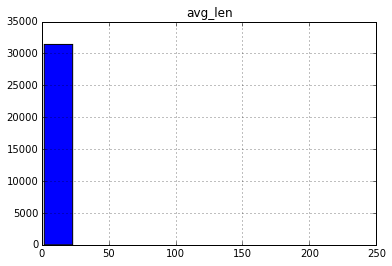

In [19]:
df.hist('avg_len')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c24ff50>]], dtype=object)

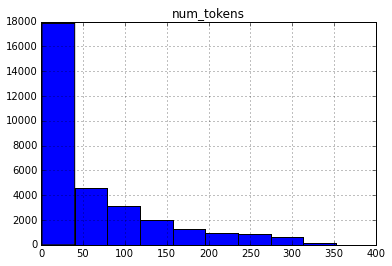

In [21]:
df.hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

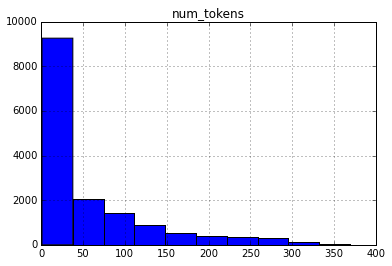

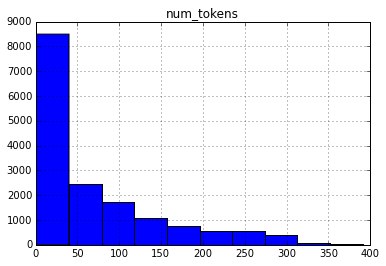

In [28]:
df.groupby('gender').hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

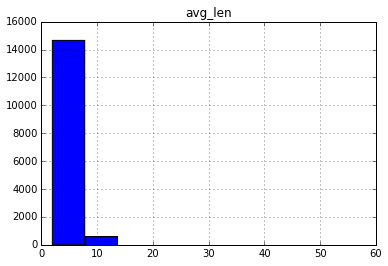

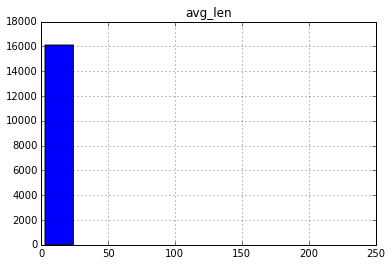

In [29]:
df.groupby('gender').hist('avg_len')

In [30]:
gender_group = df.groupby('gender')

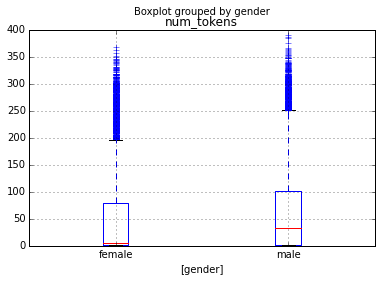

In [31]:
bp = df.boxplot(column=['num_tokens'], by=['gender'])

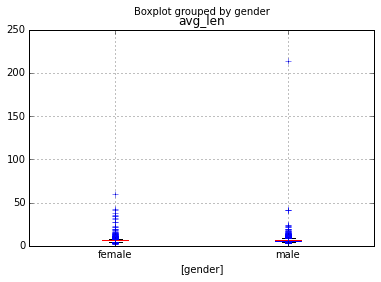

In [32]:
bp = df.boxplot(column=['avg_len'], by=['gender'])

In [27]:
gender_group.describe().T

gender       female                                                    male  \
              count       mean        std min       25% 50% 75%  max  count   
avg_len       15321   6.683214   1.269142   2  6.148936   7   7   60  16115   
class         15321   0.000000   0.000000   0  0.000000   0   0    0  16115   
counter       15321   1.000000   0.000000   1  1.000000   1   1    1  16115   
name_counts   15321  54.914953  65.998524   1  5.000000  28  85  262  16109   
num_tokens    15321  50.866066  72.993090   1  1.000000   6  79  369  16115   
summ_missing  15321   0.492200   0.499955   0  0.000000   0   1    1  16115   

gender                                                                
                   mean        std       min       25% 50%  75%  max  
avg_len        6.641086   2.012160  2.857143  5.975359   7    7  214  
class          1.000000   0.000000  1.000000  1.000000   1    1    1  
counter        1.000000   0.000000  1.000000  1.000000   1    1    1  
name_counts   72.597927  95.408108  1.000000  4.000000  36  108  404  
num_tokens    64.810735  80.899898  1.000000  1.000000  33  101  391  
summ_missing   0.394850   0.488834  0.000000  0.000000   0    1    1

In [33]:
summ_missing = df.groupby('gender').agg({'summ_missing':sum})

In [34]:
sum_gender = df.groupby('gender').agg(np.sum)

In [35]:
avg_gender = df.groupby('gender').agg(np.mean)

In [36]:
avg_gender

,counter,summ_missing,class,num_tokens,avg_len,name_counts
gender,,,,,,
female,1,0.49220,0,50.866066,6.683214,54.914953
male,1,0.39485,1,64.810735,6.641086,72.597927


In [37]:
# Only include rows with summaries
df = df[df['summ_missing'] == 0]

In [38]:
# lexical diversity = number of unique tokens / total number of tokens
df['lex_diversity'] = df['summ_tokens'].apply(lambda x: len(set(x))/len(x))


/Users/lekha/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [39]:
df.head()

,first_name,full_name,html,summary,gender,counter,source,summ_missing,class,summ_tokens,num_tokens,avg_len,name_counts,lex_diversity
0,aakash,aakash maniyar,./aakashmaniyar.html\n,hard worker driven to succeed fast learner alw...,male,1,uwash,0,1,"[hard, worker, driven, to, succeed, fast, lear...",114,5.614035,2,0.719298
1,aakash,aakash sethi,./asethi77.html\n,as a computer engineering student at the unive...,male,1,uwash,0,1,"[as, a, computer, engineering, student, at, th...",70,5.942857,2,0.828571
2,aakriti,aakriti srikanth,./2015-12-25-ut-austin/aakritisrikanth.html\n,summaryproduct management strategy business d...,female,1,utaustin,0,0,"[summaryproduct, management, strategy, busines...",61,6.967213,1,0.737705
5,aapo,aapo kyrl,./akyrola.html\n,startup entrepreneur computer scientist and en...,male,1,uwash,0,1,"[startup, entrepreneur, computer, scientist, a...",142,6.218310,1,0.711268
6,aaron,aaron alva,./aalva.html\n,aaron alva researches at the intersection of l...,male,1,uwash,0,1,"[aaron, alva, researches, at, the, intersectio...",57,5.508772,77,0.824561


gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

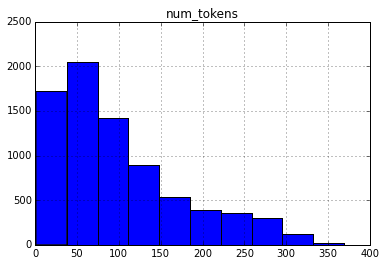

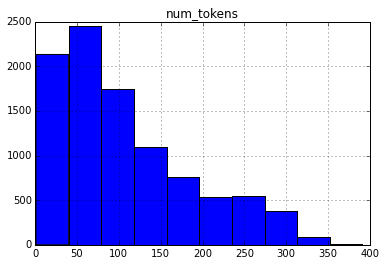

In [40]:
df.groupby('gender').hist('num_tokens')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

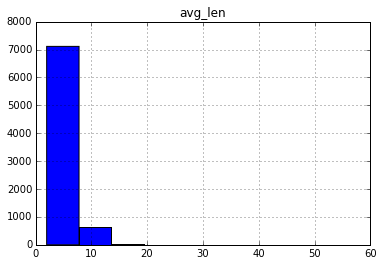

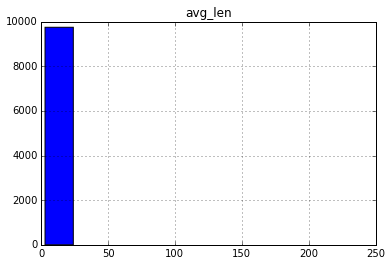

In [41]:
df.groupby('gender').hist('avg_len')

gender
female    [[Axes(0.125,0.125;0.775x0.775)]]
male      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

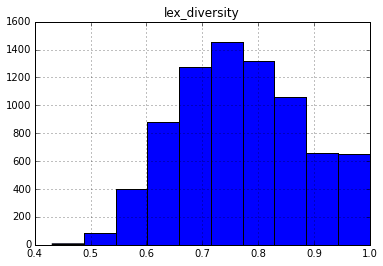

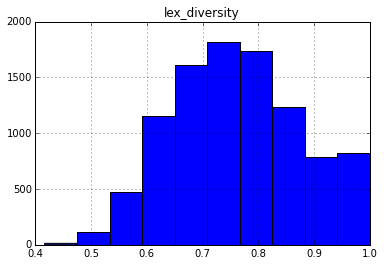

In [42]:
df.groupby('gender').hist('lex_diversity')

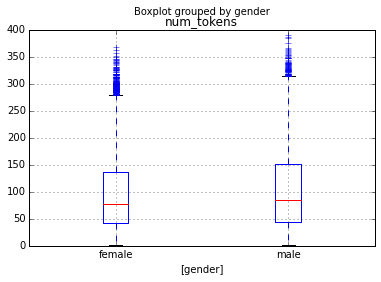

In [43]:
bp = df.boxplot(column=['num_tokens'], by=['gender'])

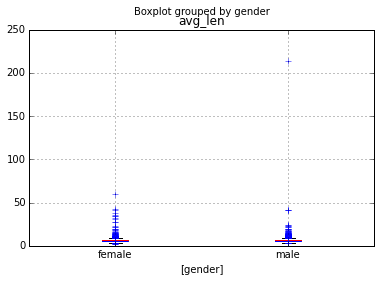

In [44]:
bp = df.boxplot(column=['avg_len'], by=['gender'])

In [45]:
# The breakdown by gender of the final dataset used for train and test
df.gender.value_counts()

male      9752
female    7780
Name: gender, dtype: int64

# Basic Vocabulary Study

In [46]:
females_df = df[df['gender']=='female']
males_df = df[df['gender'] =='male']

In [47]:
def remove_digits(mystr):
    '''
    INPUT: list of tokens 
    OUTPUT: list of tokens with digits removed
    '''
    return [word for word in mystr if not word.isdigit()]
        

In [48]:
def get_vocab(input_df):
    tokens_by_row = input_df['summ_tokens']
    vocab = []
    for row in tokens_by_row:
        row = remove_digits(row)
        for word in row:
            if word not in stopwords:
                vocab.append(word) 
    return vocab

In [49]:
vocab = get_vocab(df)

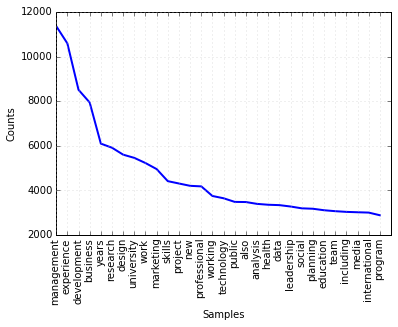

In [50]:
# freq distribution
freq_dist = nltk.FreqDist(vocab)
freq_dist.most_common(30)
freq_dist.plot(30)


In [51]:
f_vocab = get_vocab(females_df)
m_vocab = get_vocab(males_df)

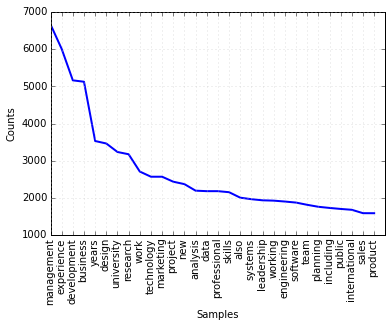

In [52]:
m_freq_dist = nltk.FreqDist(m_vocab)
#freq_dist.N
m_freq_dist.most_common(30)
#freq_dist.freq('management')
m_freq_dist.plot(30)


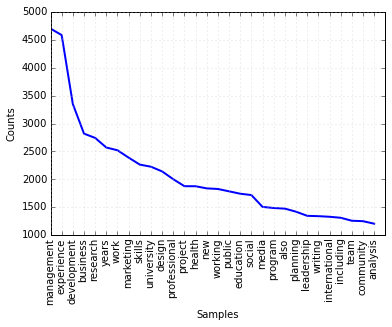

In [53]:
f_freq_dist = nltk.FreqDist(f_vocab)
#freq_dist.N
f_freq_dist.most_common(30)
#freq_dist.freq('management')
f_freq_dist.plot(30)


In [54]:
print (f_freq_dist.freq('technology'))
print (m_freq_dist.freq('technology'))

0.00212594817092
0.00369863999424


# Word Frequencies, Conditional Frequency Distribution for
* ALL,  Male, Female 

In [ ]:
>>> from nltk.probability import ConditionalFreqDist
>>> from nltk.tokenize import word_tokenize
>>> cfdist = ConditionalFreqDist()
>>> for word in word_tokenize(sent):
...     condition = len(word)
...     cfdist[condition][word] += 1

# Predict gender using summary using RF - Baseline Model

In [56]:
df['summary'] = df['summary'].astype(str)

/Users/lekha/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
df.set_value(31431, 'first_name', 'nanname')
df.set_value(31432, 'first_name', 'nanname')
df.set_value(31433, 'first_name', 'nanname')
df.set_value(31434, 'first_name', 'nanname')
df.set_value(31431, 'gender', 'female')
df.set_value(31432, 'gender', 'female')
df.set_value(31433, 'gender', 'female')
df.set_value(31434, 'gender', 'female')

,first_name,full_name,html,summary,gender,counter,source,summ_missing,class,summ_tokens,num_tokens,avg_len,name_counts,lex_diversity
0,aakash,aakash maniyar,./aakashmaniyar.html\n,hard worker driven to succeed fast learner alw...,male,1,uwash,0,1,"[hard, worker, driven, to, succeed, fast, lear...",114,5.614035,2,0.719298
1,aakash,aakash sethi,./asethi77.html\n,as a computer engineering student at the unive...,male,1,uwash,0,1,"[as, a, computer, engineering, student, at, th...",70,5.942857,2,0.828571
2,aakriti,aakriti srikanth,./2015-12-25-ut-austin/aakritisrikanth.html\n,summaryproduct management strategy business d...,female,1,utaustin,0,0,"[summaryproduct, management, strategy, busines...",61,6.967213,1,0.737705
5,aapo,aapo kyrl,./akyrola.html\n,startup entrepreneur computer scientist and en...,male,1,uwash,0,1,"[startup, entrepreneur, computer, scientist, a...",142,6.218310,1,0.711268
6,aaron,aaron alva,./aalva.html\n,aaron alva researches at the intersection of l...,male,1,uwash,0,1,"[aaron, alva, researches, at, the, intersectio...",57,5.508772,77,0.824561
8,aaron,aaron barrell,./aaronbarrell.html\n,writer and poet with years of experience parti...,male,1,uwash,0,1,"[writer, and, poet, with, years, of, experienc...",33,6.515152,77,0.787879
9,aaron,aaron day,./aaronbday.html\n,i am a versatile website developer who has a b...,male,1,uwash,0,1,"[i, am, a, versatile, website, developer, who,...",137,5.875912,77,0.664234
10,aaron,aaron browder,./aaronbrowder.html\n,software developer with 2 years of industry ex...,male,1,uwash,0,1,"[software, developer, with, 2, years, of, indu...",41,5.341463,77,0.780488
12,aaron,aaron burke,./aaronburke.html\n,software engineer with a vast array of knowled...,male,1,uwash,0,1,"[software, engineer, with, a, vast, array, of,...",63,6.555556,77,0.698413
13,aaron,aaron c,./aaronc25.html\n,i have achieved a high level of communication ...,male,1,uwash,0,1,"[i, have, achieved, a, high, level, of, commun...",50,5.660000,77,0.800000


In [59]:
# Check for any nans in the DF
df[pd.isnull(df).any(axis=1)]


,first_name,full_name,html,summary,gender,counter,source,summ_missing,class,summ_tokens,num_tokens,avg_len,name_counts,lex_diversity
31431,nanname,nan liu cpa,./liun86.html\n,serve technology industry in silicon valleyfed...,female,1,uwash,0,1,"[serve, technology, industry, in, silicon, val...",14,7.357143,NaN,1.000000
31432,nanname,nan holmes,./nanholmes.html\n,30 years of experience in office management gr...,female,1,uwash,0,1,"[30, years, of, experience, in, office, manage...",35,6.142857,NaN,0.885714
31433,nanname,nan santivong,./nansantivong.html\n,a dynamic paralegal with a wide range of exper...,female,1,uwash,0,1,"[a, dynamic, paralegal, with, a, wide, range, ...",158,5.993671,NaN,0.721519
31434,nanname,nan gaines foster,./2015-12-24-vassar/nan-foster-3226338.html\n,summaryfood nutrition leadership visual writi...,female,1,vassar,0,1,"[summaryfood, nutrition, leadership, visual, w...",137,7.262774,NaN,0.554745


In [70]:
from nltk import word_tokenize          
import pdb
stemmer = SnowballStemmer("english")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return stems

def tokenize_no_stem(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return tokens    

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df['summary'], df['class'], test_size=0.3, random_state=0)

In [72]:
temp = np.array(y_test)
len(temp[(temp == 0)])

2347

In [73]:
print ("Creating the bag of words...\n")
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = tokenize_no_stem,    \
                             preprocessor = None, \
                             stop_words = stopwords,   \
                             max_features = 5000) 

Creating the bag of words...



In [74]:
tfidf = TfidfVectorizer(analyzer = 'word', tokenizer = tokenize_no_stem, stop_words = stopwords, max_features = 5000)

In [75]:
train_tfidf = tfidf.fit_transform(X_train)

In [101]:
X_train.shape

(12272,)

In [76]:
train_tfidf = train_tfidf.toarray()
feature_names_tfidf = tfidf.get_feature_names()

In [105]:
feature_names_tfidf[1]

u'10'

In [77]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_countv = vectorizer.fit_transform(X_train)

In [78]:
# Numpy arrays are easy to work with, so convert the result to an 
# array
train_countv= train_countv.toarray()
feature_names_countv = vectorizer.get_feature_names()

In [82]:
# Take a look at the words in the vocabulary
print (feature_names_countv)

[u'1', u'10', u'100', u'1000', u'11', u'12', u'13', u'14', u'15', u'150', u'16', u'17', u'18', u'19', u'1984', u'1986', u'1988', u'1989', u'1990', u'1991', u'1992', u'1993', u'1994', u'1995', u'1996', u'1997', u'1998', u'1999', u'1st', u'2', u'20', u'200', u'2000', u'2001', u'2002', u'2003', u'2004', u'2005', u'2006', u'2007', u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2015', u'2016', u'21', u'21st', u'22', u'23', u'24', u'25', u'250', u'26', u'27', u'28', u'2d', u'2nd', u'3', u'30', u'300', u'35', u'360', u'365', u'3d', u'3rd', u'4', u'40', u'400', u'45', u'4th', u'5', u'50', u'500', u'501c3', u'6', u'60', u'7', u'70', u'700', u'8', u'80', u'9', u'90', u'ab', u'abc', u'abilities', u'ability', u'able', u'abroad', u'abstract', u'abuse', u'academia', u'academic', u'academically', u'academics', u'academy', u'accelerate', u'accelerating', u'accenture', u'accept', u'acceptance', u'accepted', u'access', u'accessibility', u'accessible', u'accident', u'acclaimed', u'accom

In [83]:
print ("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest_cv = forest.fit(train_countv, y_train)

forest_tfidf = forest.fit(train_tfidf, y_train)

Training the random forest...


In [84]:
forest_cv

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [86]:
# Testing

# Get a bag of words for the test set, and convert to a numpy array
#test_data_features = vectorizer.transform(X_test)
test_features_tfidf = tfidf.transform(X_test)
test_features_tfidf = test_features_tfidf.toarray()

# Use the random forest to make sentiment label predictions
yhat = forest_tfidf.predict(test_features_tfidf)
probX = forest_tfidf.predict_proba(test_features_tfidf)


In [87]:
acc = forest.score(test_features_tfidf, y_test)

In [88]:
acc

0.64961977186311792

In [89]:
yhat.shape

(5260,)

In [91]:
print ("Precision Score: {0}".format(precision_score(y_test, yhat)))
print ("Recall Score: {0}".format(recall_score(y_test, yhat)))
print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat)))
print ("Model Score:{0}".format(forest.score(test_features_tfidf, y_test)))

Precision Score: 0.667396745932
Recall Score: 0.732234809475
AUC Score: 0.63965809498
Model Score:0.649619771863


In [ ]:
# print ("Precision Score: {0}".format(precision_score(y_test, yhat1)))
# print ("Recall Score: {0}".format(recall_score(y_test, yhat1)))
# print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat1)))
# print ("Model Score:{0}".format(forest.score(test_data_features, y_test)))

In [92]:
fpr, tpr, thresholds = roc_curve(y_test, probX[:,1])

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probX[:,1])

In [ ]:
fpr2, tpr2, thresholds2 = roc_curve(y_test, probX[:,1])

In [ ]:
thresholds[1:10]

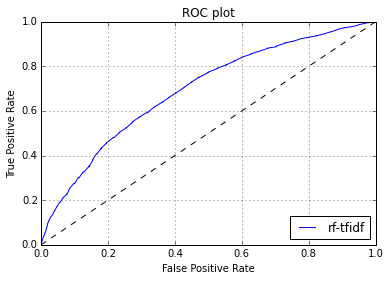

In [93]:
# ROC Curve
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.array(range(101))/100, np.array(range(101))/100, '--', color='black')
plt.plot(fpr, tpr, label='rf-tfidf')
#plt.plot(fpr1, tpr1, label='rf-stemmed')
#plt.plot(fpr2, tpr2, label='rf-tfidf')
plt.ylabel("True Positive Rate ")
plt.xlabel("False Positive Rate")
plt.title("ROC plot")
plt.legend(loc='lower right')

plt.grid()
plt.show()



In [98]:
df['summary'].values

array([ 'hard worker driven to succeed fast learner always looking for new things to explore interested in computer programming in the gaming industry robotics enthusiast involved in robotics clubs at the university of washington while also having a successful 4 year high school career made it to multiple regional and national championships while being a leader and having 4 years of hands on experience with building wiring and coding robots of different sizespassionate about business as well by being a member of fbla throughout highschool going to multiple state championships in different categories accomplished math tutor and math student with many individual accolades and awards for math competitions across washington and nationally throughout the us',
       'as a computer engineering student at the university of washington i aim to learn and apply the skills necessary to help make technology more powerful accessible and economical for as many people as possiblei am primarily intere

In [110]:
# Most important features
num = 50
imp = forest.feature_importances_
feature_names = np.array(feature_names_tfidf)
features = feature_names[np.argsort(imp)[-num:]]
weights = imp[np.argsort(imp)[-num:]]
feats_with_vals = zip(features, weights)
for x in feats_with_vals:
    print (x)


(u'people', 0.0017853671613047911)
(u'leadership', 0.0017877574809428863)
(u'arts', 0.0018052897877076459)
(u'data', 0.0018211160732833295)
(u'team', 0.0018236654347283251)
(u'career', 0.0018352487186651222)
(u'art', 0.0018487444592233545)
(u'currently', 0.0018650957748702645)
(u'planning', 0.0018940588690310449)
(u'human', 0.0019238664301314901)
(u'washington', 0.0019569094671330763)
(u'communication', 0.001974151696114956)
(u'creative', 0.0019775798314892513)
(u'sales', 0.0020322011396523682)
(u'teaching', 0.0021107132990096718)
(u'new', 0.0022837306353809257)
(u'technical', 0.0023018950361993586)
(u'program', 0.0023316782819724356)
(u'communications', 0.0023332575956042266)
(u'university', 0.0023522332268117781)
(u'work', 0.0024286505183380345)
(u'passionate', 0.0024391026919387947)
(u'analysis', 0.0024448986284399681)
(u'project', 0.0025615818455407276)
(u'systems', 0.0026014676917429651)
(u'college', 0.0026173868367481007)
(u'years', 0.0026333825569791109)
(u'public', 0.0026804801

# Topic Modeling with 5000 features: NMF

### 1. All profiles

In [ ]:
females = df[df['gender'] == 'female']
males = df[df['gender'] == 'male']

In [ ]:
X = df['summ_tokens']
y = np.array(df['class'])

In [ ]:
# Print the top 20 words and weights for each topic
def print_top_weights(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        #print (top_weights)
        print (" ".join(["{0}, {1}".format(feature_names[x], topic[x]) for x in top_weights]))
    print()
    

# Print the most probable topic for each document/profile
def profiles_by_topic(W):
    top_idx = np.zeros([W.shape[0],1], dtype=float)
    for row_idx, row in enumerate(W):
        topic_idx = row.argsort()[-1]  
        top_idx[row_idx] = topic_idx
    topics, counts = np.unique(top_idx, return_counts=True)
    print (np.asarray((topics, counts)).T)
    return top_idx

In [ ]:
#tokenize: function that is stemming using SnowballStemmer
#stopwords: custom stop words
def run_topic_model_tfidf(X, stopwords):
    print ("Bag of Words, Tfidf\n")
    
    vectorizer = TfidfVectorizer(analyzer = 'word', tokenizer = tokenize_no_stem, stop_words = stopwords, max_features = 5000)
    word_frequencies = vectorizer.fit_transform(X)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    word_frequencies = word_frequencies.toarray()
    feature_names = vectorizer.get_feature_names()

    # NMF Model to determine topics
    nmf_model = NMF(n_components=7, init='random', random_state=0)
    W = nmf_model.fit_transform(word_frequencies)
    # H: Topics * Words
    H = nmf_model.components_
    print (H.shape, W.shape)
    
    n_top_words = 20
    # Print weights and topics for the top 20 topics
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        print (" ".join(["{0}".format(feature_names[x]) for x in top_weights]))
    print()
    
    # Highest Weighted Topic for each profile
    print ("Number of profiles by topic\n")
    top_idx = profiles_by_topic(W) 
    
    return nmf_model, W, top_idx

In [ ]:
#tokenize: function that is stemming using SnowballStemmer
#stopwords: custom stop words
def run_topic_model_countv(X, stopwords):
    print ("Bag of words, Count Vectorizer...\n")
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = tokenize_no_stem,    \
                                 preprocessor = None, \
                                 stop_words = stopwords,   \
                                 max_features = 5000) 


    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings.
    word_frequencies = vectorizer.fit_transform(X)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    word_frequencies = word_frequencies.toarray()
    feature_names = vectorizer.get_feature_names()

    # NMF Model to determine topics
    nmf_model = NMF(n_components=10, init='random', random_state=0)
    W = nmf_model.fit_transform(word_frequencies)
    # H: Topics * Words
    H = nmf_model.components_
    print (H.shape, W.shape)
    
    n_top_words = 20
    # Print weights and topics for the top 20 topics
    for topic_idx, topic in enumerate(H):
        print("Topic #%d:" % topic_idx)
        top_weights = topic.argsort()[:-n_top_words - 1:-1]
        #print (" ".join(["{0}".format(feature_names[x]) for x in top_weights]))
        print (" ".join(["{0}, {1}".format(feature_names[x], topic[x]) for x in top_weights]))
    print()
    
    print ("Number of profiles by Topic\n")
    top_idx = profiles_by_topic(W)
    
    print ("Example Profiles by Topic\n")
    
    
    return nmf_model, W, top_idx

# Topics for Female Profiles - TFIDF

In [ ]:
X = females['summary']
y = np.array(females['class'])

nmf_model, W, top_idx = run_topic_model_tfidf(X, stopwords)


# Female Topics - Count Vectorizer

In [ ]:
X = females['summary']
y = np.array(females['class'])

nmf_model, W, top_idx = run_topic_model_countv(X, stopwords)



# Topics for Male Profiles - TFIDF

In [ ]:
X = males['summary']
y = np.array(males['class'])

nmf_model, W, top_idx = run_topic_model_tfidf(X, stopwords)


# Male Topics - CountVectorizer

In [ ]:
X = males['summary']
y = np.array(males['class'])

nmf_model, W, top_idx = run_topic_model_countv(X, stopwords)

In [ ]:
# Number of profiles clustered by topic number
# Do this again after stemming

In [ ]:
top_idx[1:10]

In [ ]:
males.ix[0]['summary'] # Topic 3

In [ ]:
males.ix[1]['summary'] # Topic 4

In [ ]:
males.ix[4]['summary'] # Topic 9

In [ ]:
# Generating a word cloud:
#https://github.com/amueller/word_cloud/blob/master/examples/simple.py
    
from os import path
from wordcloud import WordCloud

d = path.dirname(__file__)

# Read the whole text.
text = open(path.join(d, 'constitution.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#http://stanford.edu/~mwaskom/software/seaborn/examples/grouped_boxplot.html
import seaborn as sns
sns.set(style="ticks")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="day", y="total_bill", hue="sex", data=tips, palette="PRGn")
sns.despine(offset=10, trim=True)